In [1]:
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter

from stardist.models import StarDist2D
from csbdeep.utils import normalize
from skimage import exposure
import matplotlib.patches as patches

from typing import Any
from tqdm import tqdm
import dask.array as da
import tensorflow as tf
import numpy as np
import pandas as pd
import SimpleITK as sitk

import matplotlib.pyplot as plt
import pyclesperanto_prototype as cle

2023-07-11 14:58:40.977507: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-11 14:58:41.011359: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 14:58:41.615240: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
img = []
img.append(AICSImage("./output/preprocessing/PercentileNormalization/CancerCell.tif"))  # selects the first scene found
img.append(AICSImage("./output/preprocessing/PercentileNormalization/TCell.tif"))

image = []
image.append(img[0].get_image_dask_data("XYT").persist())
image.append(img[1].get_image_dask_data("XYT").persist())

In [3]:
lbl = []
lbl.append(AICSImage("./output/segmentation/StarDist/CancerCell.tif"))  # selects the first scene found
lbl.append(AICSImage("./output/segmentation/StarDist/TCell.tif"))

label = []
label.append(lbl[0].get_image_dask_data("XYT").persist())
label.append(lbl[1].get_image_dask_data("XYT").persist())

In [4]:
feature = []

feature.append(pd.read_csv("./output/tracking/Alive.csv",index_col="label"))
feature.append(pd.read_csv("./output/tracking/TCell.csv",index_col="label"))

In [5]:
feature[0][feature[0].frame==0][["i","j"]]

,i,j
label,,
1,108.512744,567.467766
2,842.816667,684.808333
3,949.008361,571.934783
4,571.595104,187.849341
5,973.373494,805.335341
...,...,...
754,739.000000,453.500000
755,227.000000,518.000000
756,791.000000,145.000000


In [6]:
feature[1][feature[1].frame==0][["i","j"]]

,i,j
label,,
1,737.856269,764.247706
2,636.244726,584.848101
3,7.688596,755.653509
4,731.353982,785.544248
5,740.800000,641.809091
...,...,...
519,270.000000,116.000000
520,808.000000,873.000000
521,152.000000,1004.000000


cl.OCLArray([[   0.     ,    0.     ,    0.     , ...,    0.     ,    0.     ,
           0.     ],
       [   0.     ,  659.3903 ,  131.63316, ...,  621.5239 ,  565.3409 ,
         693.105  ],
       [   0.     ,  528.01807,  229.48639, ...,  466.27838,  413.3631 ,
         498.53995],
       ...,
       [   0.     ,  438.69296,  760.9934 , ..., 1070.6083 ,  489.9306 ,
         728.4573 ],
       [   0.     ,  769.1736 ,  227.43866, ...,  323.78543,  644.8915 ,
         653.701  ],
       [   0.     ,  539.8733 ,  854.2318 , ...,  530.2198 ,  469.7925 ,
         230.70544]], dtype=float32)
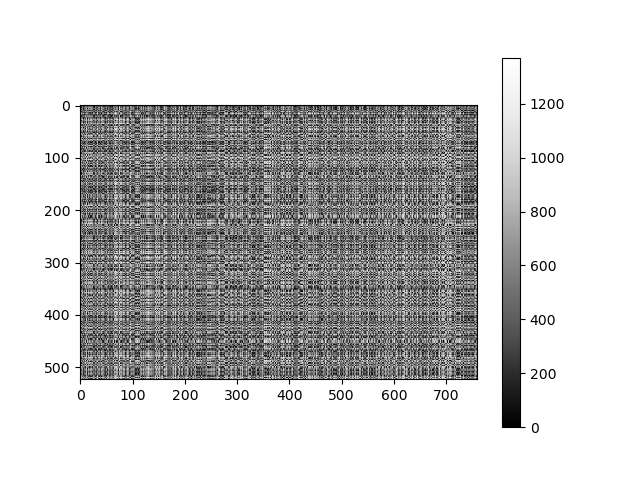
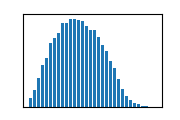

In [7]:
distance_matrix = cle.generate_distance_matrix(feature[0][feature[0].frame==0][["i","j"]].to_numpy().T, feature[1][feature[1].frame==0][["i","j"]].to_numpy().T)
distance_matrix

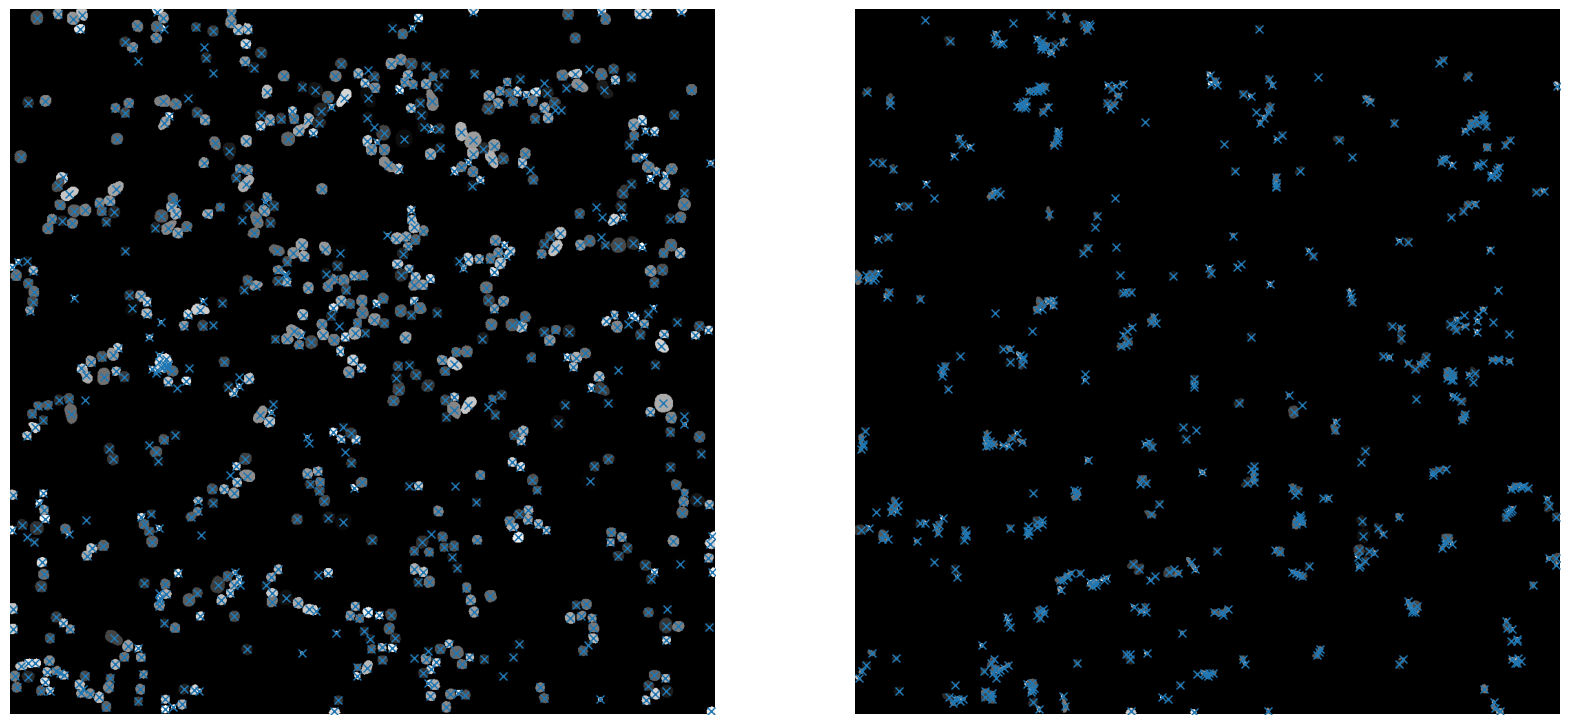

In [8]:
fig, axs = plt.subplots(1,2,figsize=[20,10])
axs[0].imshow(label[0][:,:,0],cmap="gray")
axs[0].axis("off")
axs[0].plot(feature[0][feature[0].frame==0].i,feature[0][feature[0].frame==0].j,"x")
axs[1].imshow(label[1][:,:,0],cmap="gray")
axs[1].axis("off")
axs[1].plot(feature[1][feature[1].frame==0].i,feature[1][feature[1].frame==0].j,"x")

In [9]:
statFilter = sitk.LabelShapeStatisticsImageFilter()
statFilter.Execute(sitk.GetImageFromArray(label[0][:,:,0]))
print(statFilter.GetNumberOfLabels())
statFilter.Execute(sitk.GetImageFromArray(label[1][:,:,0]))
print(statFilter.GetNumberOfLabels())

758
523


cl.OCLArray([[1., 1., 1., ..., 0., 1., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)
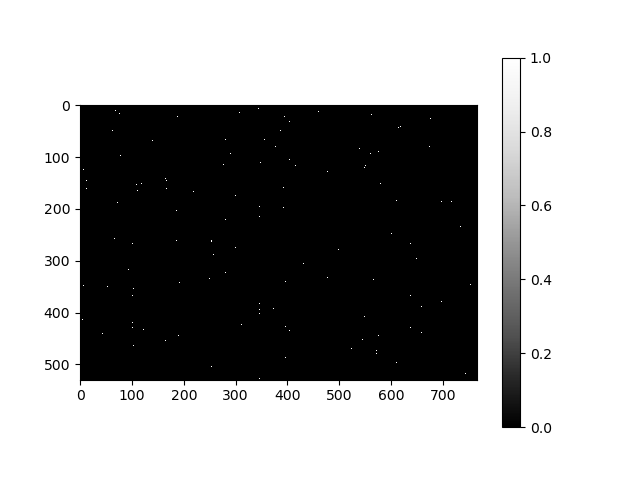
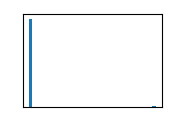

In [10]:
overlap_matrix = cle.generate_binary_overlap_matrix(label[0][:,:,0], label[1][:,:,0])
overlap_matrix

In [11]:
label_relabel = []
relabel = sitk.RelabelComponentImageFilter()
label_ = sitk.GetImageFromArray(label[0][:,:,0])
label_relabel.append(sitk.GetArrayFromImage(relabel.Execute(label_)))

label_ = sitk.GetImageFromArray(label[1][:,:,0])
label_relabel.append(sitk.GetArrayFromImage(relabel.Execute(label_)))

In [12]:
statFilter = sitk.LabelShapeStatisticsImageFilter()
statFilter.Execute(sitk.GetImageFromArray(label_relabel[0]))
print(statFilter.GetNumberOfLabels())
statFilter.Execute(sitk.GetImageFromArray(label_relabel[1]))
print(statFilter.GetNumberOfLabels())

758
523


cl.OCLArray([[1., 1., 1., ..., 1., 1., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)
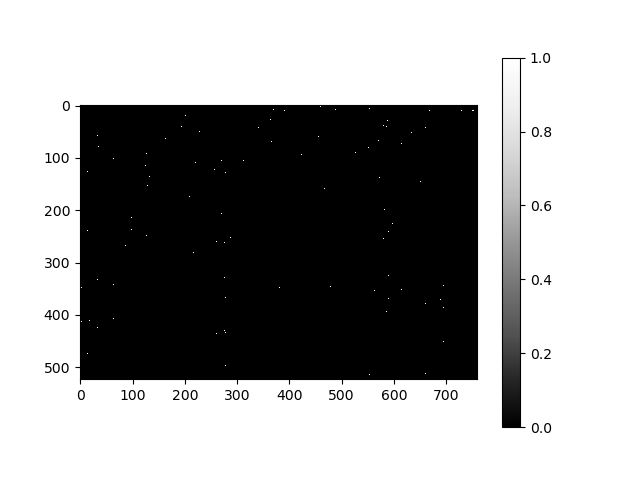
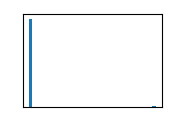

In [13]:
overlap_matrix = cle.generate_binary_overlap_matrix(label_relabel[0], label_relabel[1])
overlap_matrix

## To pandas table

In [14]:
f_0 = feature[1][feature[1].frame==0]
f_0

,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,bbox_jstart,...,feret_diameter,feret_radius,perimeter,mass,mean,median,sd,frame,channel,alive
label,,,,,,,,,,,,,,,,,,,,,
1,764.247706,737.856269,729,754,19,22,737.856269,764.247706,729.0,754.0,...,21.377558,10.688779,64.412226,15352636.0,46949.957187,65407.001953,24471.200726,0,TCell,NaN
2,584.848101,636.244726,629,576,15,19,636.244726,584.848101,629.0,576.0,...,19.313208,9.656604,55.026916,11961424.0,50470.143460,65407.001953,23435.927962,0,TCell,NaN
3,755.653509,7.688596,0,748,19,16,7.688596,755.653509,0.0,748.0,...,20.591260,10.295630,56.367675,11615820.0,50946.578947,65407.001953,22601.533650,0,TCell,NaN
4,785.544248,731.353982,724,777,16,18,731.353982,785.544248,724.0,777.0,...,18.384776,9.192388,55.256954,12483818.0,55238.132743,65407.001953,21345.860038,0,TCell,NaN
5,641.809091,740.800000,733,633,16,18,740.800000,641.809091,733.0,633.0,...,18.601075,9.300538,53.916196,10776427.0,48983.759091,65407.001953,24394.754579,0,TCell,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,116.000000,270.000000,270,116,1,1,270.000000,116.000000,270.0,116.0,...,0.000000,0.000000,2.681517,1286.0,1286.000000,1407.978516,0.000000,0,TCell,NaN
520,873.000000,808.000000,808,873,1,1,808.000000,873.000000,808.0,873.0,...,0.000000,0.000000,2.681517,65535.0,65535.000000,65407.001953,0.000000,0,TCell,NaN
521,1004.000000,152.000000,152,1004,1,1,152.000000,1004.000000,152.0,1004.0,...,0.000000,0.000000,2.681517,3803.0,3803.000000,3711.943359,0.000000,0,TCell,NaN


In [21]:
try:
    overlap_matrix_host = cle.pull(overlap_matrix)
    overlap_matrix.data.release()
    del overlap_matrix
except:
    pass

try:
    distance_matrix_host = cle.pull(distance_matrix)
    distance_matrix.data.release()
    del distance_matrix
except:
    pass

contact = []
contact_id = []
closest_cell_dist = []

for i in range(len(f_0.index)+1):
    if i == 0:
        continue
    overlap = overlap_matrix_host[i,1:]
    dist = distance_matrix_host[i,1:]
    
    contact.append(True) if np.sum(overlap)>0 else contact.append(False)
    contact_id.append(np.where(overlap == 1)[0])
    closest_cell_dist.append(np.min(dist))

f_0["contact"] = contact
f_0["contacting cell ids"] = contact_id
f_0["closest cell dist"] = closest_cell_dist
f_0

1562403345.py (33): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
1562403345.py (34): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
1562403345.py (35): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,bbox_jstart,...,mass,mean,median,sd,frame,channel,alive,contact,contacting cell ids,closest cell dist
label,,,,,,,,,,,,,,,,,,,,,
1,764.247706,737.856269,729,754,19,22,737.856269,764.247706,729.0,754.0,...,15352636.0,46949.957187,65407.001953,24471.200726,0,TCell,NaN,True,"[261, 513]",2.707737
2,584.848101,636.244726,629,576,15,19,636.244726,584.848101,629.0,576.0,...,11961424.0,50470.143460,65407.001953,23435.927962,0,TCell,NaN,True,"[21, 458]",7.880664
3,755.653509,7.688596,0,748,19,16,7.688596,755.653509,0.0,748.0,...,11615820.0,50946.578947,65407.001953,22601.533650,0,TCell,NaN,True,"[251, 685]",4.844902
4,785.544248,731.353982,724,777,16,18,731.353982,785.544248,724.0,777.0,...,12483818.0,55238.132743,65407.001953,21345.860038,0,TCell,NaN,False,[],19.704807
5,641.809091,740.800000,733,633,16,18,740.800000,641.809091,733.0,633.0,...,10776427.0,48983.759091,65407.001953,24394.754579,0,TCell,NaN,False,[],15.233159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,116.000000,270.000000,270,116,1,1,270.000000,116.000000,270.0,116.0,...,1286.0,1286.000000,1407.978516,0.000000,0,TCell,NaN,False,[],16.571985
520,873.000000,808.000000,808,873,1,1,808.000000,873.000000,808.0,873.0,...,65535.0,65535.000000,65407.001953,0.000000,0,TCell,NaN,False,[],12.319090
521,1004.000000,152.000000,152,1004,1,1,152.000000,1004.000000,152.0,1004.0,...,3803.0,3803.000000,3711.943359,0.000000,0,TCell,NaN,False,[],15.271957


730.0 759.0 16.0 16.0
721.0 746.0 18.0 12.0


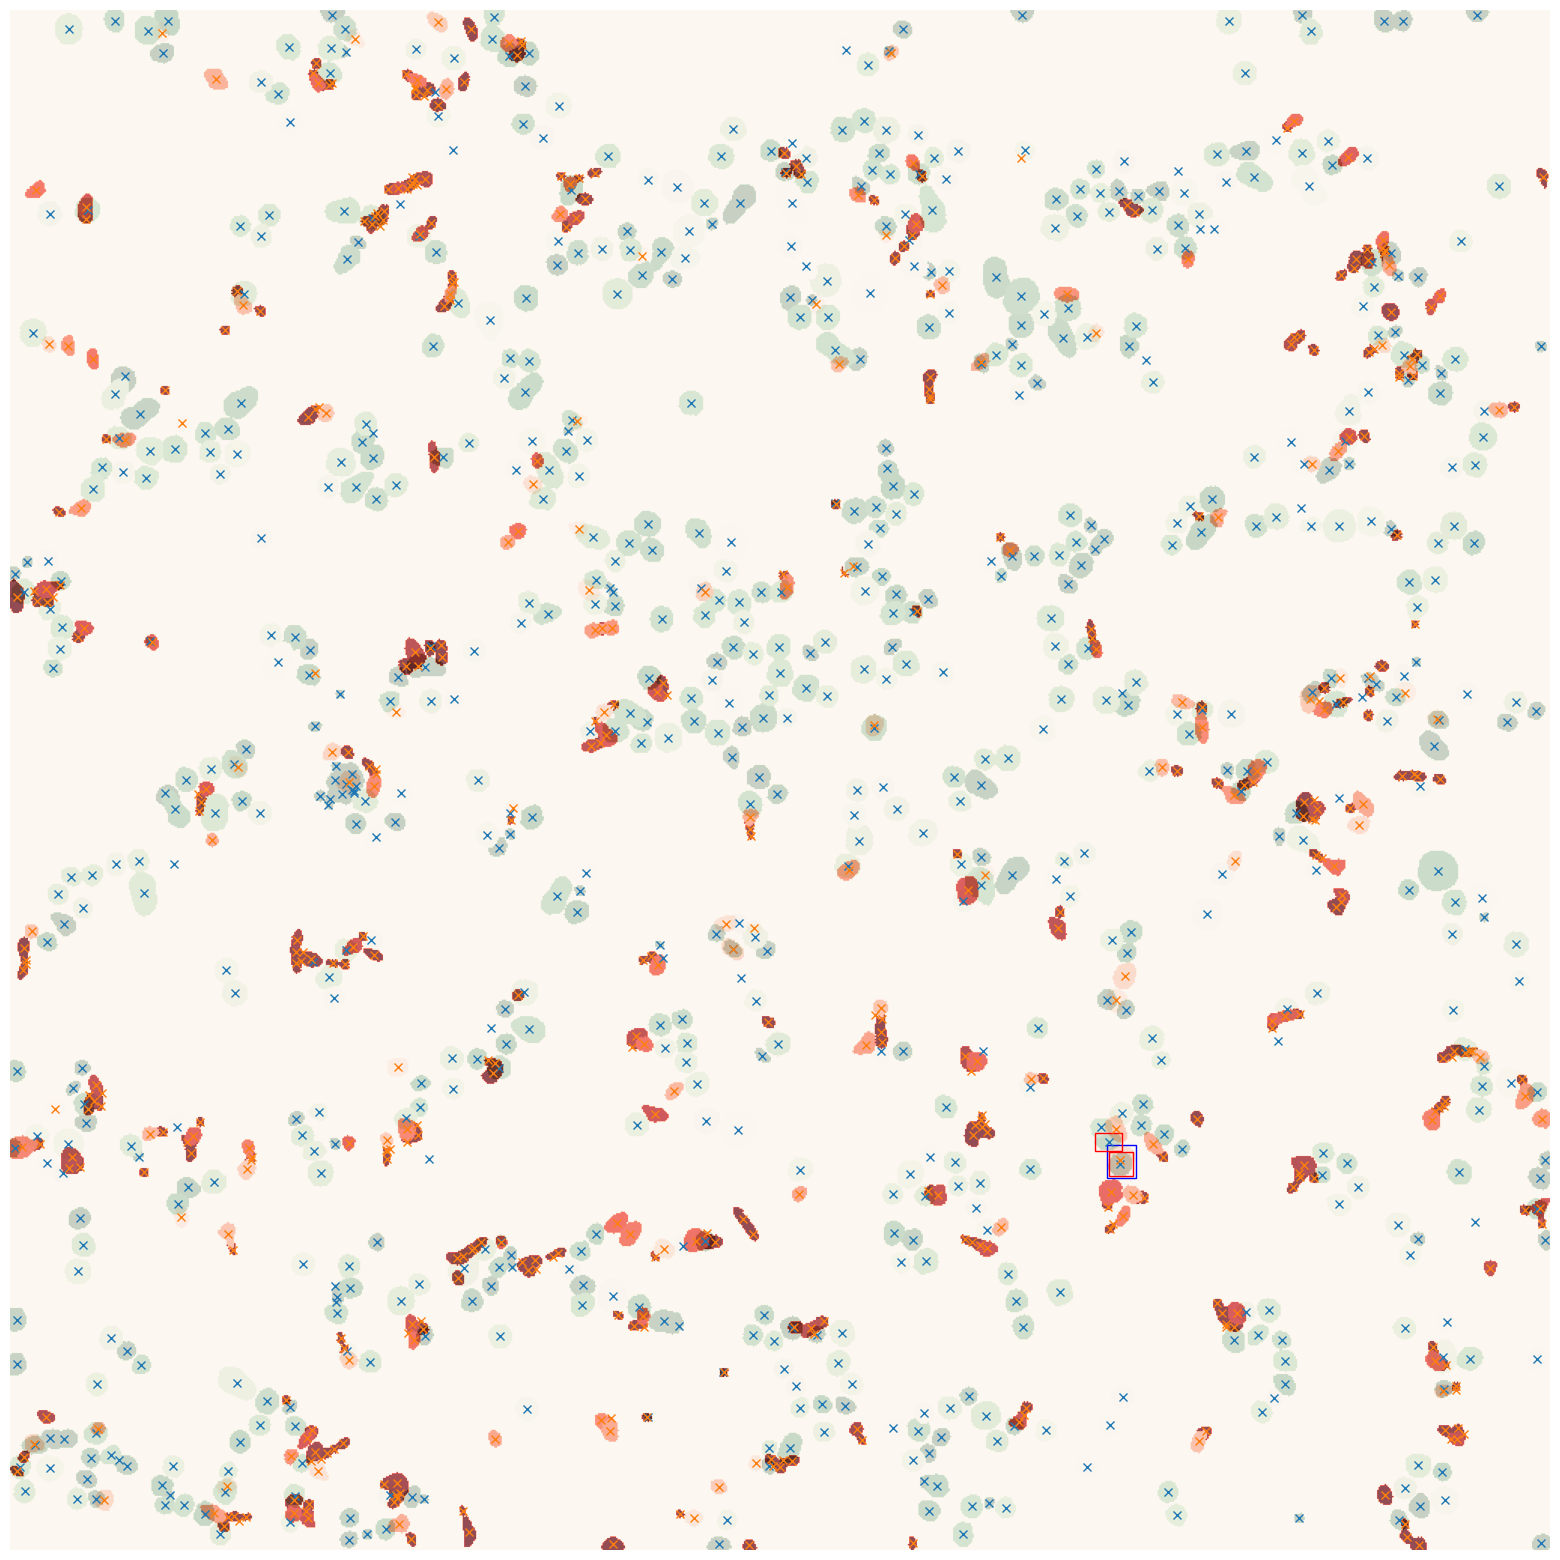

In [23]:
fig, ax = plt.subplots(1,1,figsize=[20,20])
ax.set_axis_off()
tail = 1
pl, pu = np.percentile(np.ravel(label[0][:,:,0]), (tail, 100-tail))
frame = label[0][:,:,0]
ax.imshow(exposure.rescale_intensity(frame, in_range=(pl.compute(), pu.compute()),out_range=(0,255)),cmap='Greens',alpha=0.7)
ax.plot(feature[0][feature[0].frame==0].i,feature[0][feature[0].frame==0].j,"x")
pl, pu = np.percentile(np.ravel(label[1][:,:,0]), (tail, 100-tail))
frame = label[1][:,:,0]
ax.imshow(exposure.rescale_intensity(frame, in_range=(pl.compute(), pu.compute()),out_range=(0,255)),cmap='Reds',alpha=0.7)
ax.plot(feature[1][feature[1].frame==0].i,feature[1][feature[1].frame==0].j,"x")

# Create a Rectangle patch
rect = patches.Rectangle((f_0.bbox_istart.iloc[0], f_0.bbox_jstart.iloc[0]), f_0.bbox_isize.iloc[0], f_0.bbox_jsize.iloc[0], linewidth=1, edgecolor='b', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

f_1 = feature[0][feature[0].frame==0]

# Create a Rectangle patch
ids = f_0["contacting cell ids"].iloc[0]

for id in ids:
    print(f_1.bbox_istart.iloc[id], f_1.bbox_jstart.iloc[id], f_1.bbox_isize.iloc[id], f_1.bbox_jsize.iloc[id])
    rect = patches.Rectangle((f_1.bbox_istart.iloc[id], f_1.bbox_jstart.iloc[id]), f_1.bbox_isize.iloc[id], f_1.bbox_jsize.iloc[id], linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)